# Big Data Analyse

In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


c:\Users\dell_\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Generate synthetic data (10 million rows)
n = 10**7
data = {
    'feature1': np.random.rand(n),
    'feature2': np.random.rand(n),
    'feature3': np.random.rand(n),
    'target': np.random.rand(n)
}
df = pd.DataFrame(data)

# Save to CSV (simulate a large dataset)
df.to_csv('large_dataset.csv', index=False)

# Verify data is saved
print(df.head())


   feature1  feature2  feature3    target
0  0.835221  0.057635  0.685527  0.879330
1  0.571654  0.952435  0.424813  0.857286
2  0.737001  0.206562  0.333118  0.903923
3  0.942410  0.686491  0.879914  0.740231
4  0.885086  0.287856  0.583080  0.176361


In [3]:
# Load large dataset using Dask
dask_df = dd.read_csv('large_dataset.csv')

# Show the first few rows (Dask DataFrame)
print(dask_df.head())


   feature1  feature2  feature3    target
0  0.835221  0.057635  0.685527  0.879330
1  0.571654  0.952435  0.424813  0.857286
2  0.737001  0.206562  0.333118  0.903923
3  0.942410  0.686491  0.879914  0.740231
4  0.885086  0.287856  0.583080  0.176361


In [4]:
# Handle missing values: Fill missing with column mean
dask_df = dask_df.fillna(dask_df.mean().compute())

# Drop duplicates (parallelized operation)
dask_df = dask_df.drop_duplicates()

# Check for missing values
missing_values = dask_df.isnull().sum().compute()
print("Missing values:\n", missing_values)


Missing values:
 feature1    0
feature2    0
feature3    0
target      0
dtype: int64


In [6]:
# Compute the sum of 'feature1' across all records in parallel
feature1_sum = dask_df['feature1'].sum().compute()
print(f"Sum of feature1: {feature1_sum}")

# Compute the mean of 'feature2'
feature2_mean = dask_df['feature2'].mean().compute()
print(f"Mean of feature2: {feature2_mean}")

# Create a new feature by combining 'feature1' and 'feature2'
dask_df['new_feature'] = dask_df['feature1'] * dask_df['feature2']

# Trigger computation and perform an aggregation
aggregated = dask_df.groupby('feature1').agg({'target': 'mean'}).compute()
print(aggregated.head())


Sum of feature1: 5000151.614233848
Mean of feature2: 0.4999790903214642
            target
feature1          
0.835221  0.879330
0.571654  0.857286
0.737001  0.903923
0.942410  0.740231
0.885086  0.176361


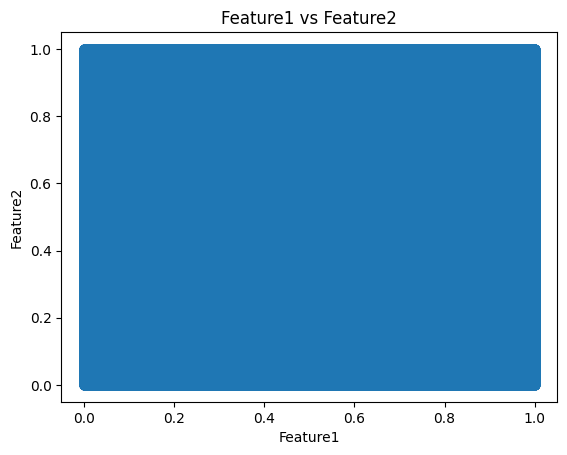

In [7]:
# Convert Dask DataFrame to pandas for visualization (only a small portion)
df_for_plotting = dask_df.compute()

# Plot correlation between feature1 and feature2
plt.scatter(df_for_plotting['feature1'], df_for_plotting['feature2'])
plt.title('Feature1 vs Feature2')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.show()


In [9]:
# Save the processed data to Parquet for efficient storage
dask_df.to_parquet('processed_large_data.parquet')
print("Data saved in Parquet format.")


Data saved in Parquet format.


In [14]:
from dask_ml.linear_model import LinearRegression
from dask.array import from_array

# Prepare the features (convert Dask DataFrame to Dask Array)
X = dask_df[['feature1', 'feature2']].to_dask_array(lengths=True)
y = dask_df['target'].to_dask_array(lengths=True)

# Train a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Model coefficients
print(f"Model coefficients: {model.coef_}")


Model coefficients: [-0.00017982 -0.00053337]


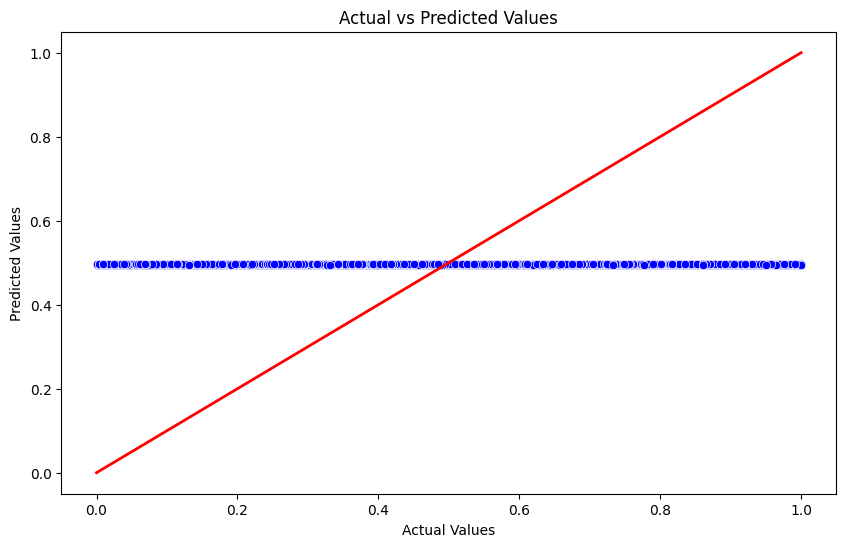

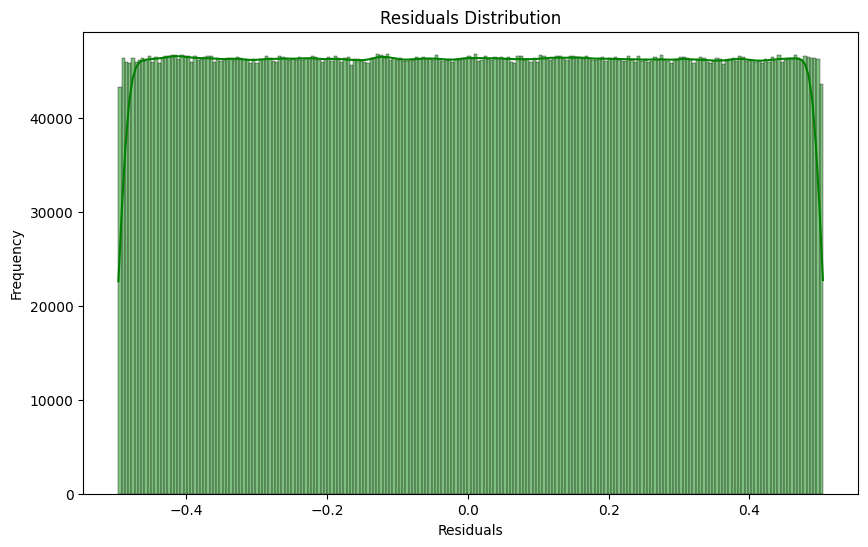

In [16]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from dask_ml.linear_model import LinearRegression
from dask.array import from_array

# Assuming dask_df is your Dask DataFrame and you've already trained your model

# Convert to Dask Array
X = dask_df[['feature1', 'feature2']].to_dask_array(lengths=True)
y = dask_df['target'].to_dask_array(lengths=True)

# Train the model
model = LinearRegression()
model.fit(X, y)

# Make predictions using the trained model
predictions = model.predict(X)

# Convert Dask Array to numpy array for visualization
y_actual = y.compute()  # actual target values
y_pred = predictions.compute()  # predicted target values

# Create a DataFrame for easy visualization
import pandas as pd
results_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})

# Visualization: Actual vs Predicted
plt.figure(figsize=(10,6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df, color='blue')
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()],
         color='red', lw=2)  # Line showing perfect prediction
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Visualization: Residuals (Error) Plot
residuals = y_actual - y_pred
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True, color='green')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
